In [1]:

import numpy as np

print(np.__version__)


2.0.2


In [2]:
# import required packages
import time
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.integrate import odeint

# import MAGI-X packages
from scripts.magix.dynamic import nnSTModule, nnMTModule # neural network module
from scripts.magix.inference import FMAGI # inferred module

### LV

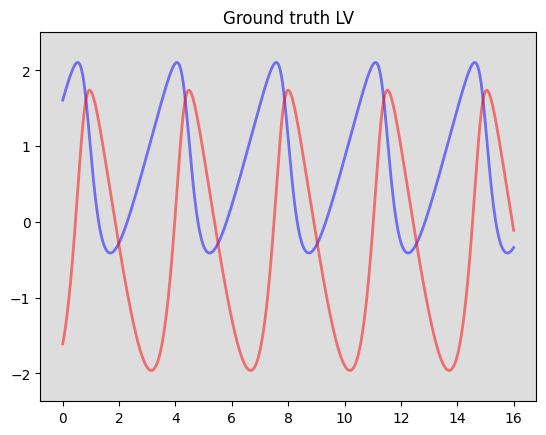

In [10]:
# define FitzHugh-Nagumo model dynamic
def LV(y, t, a, b, c, d):
	P, D = y # Prey, Predator
	dPdt = a * P - b * P * D
	dDdt = c * P * D - d * D
	return (dPdt,dDdt)
# model parameters
a, b, c, d = 1.5, 1, 1, 3
# initial condition
P0, D0 = 5, 0.2 
y0 = P0, D0
# time point for evaluation
tdata = np.linspace(0, 16, 1281)
# integration
xdata = odeint(LV, y0, tdata, args = (a,b,c,d))
xdata = np.log(xdata)


# visualization
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(tdata, xdata[:,0], 'b', alpha=0.5, lw=2, label='V')
ax.plot(tdata, xdata[:,1], 'r', alpha=0.5, lw=2, label='R')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Ground truth LV')
plt.show()

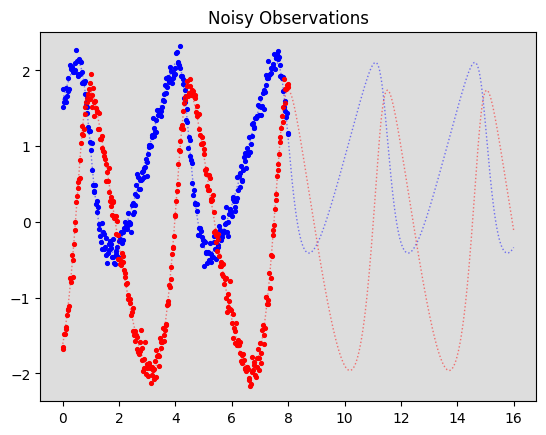

In [11]:
# setting
seed = 188714368 # random seed
noise = [0.1,0.1] # noise level
no_train = 321 # number of training samples 41/81/161/321/641/1281

# observation
obs = []
no_comp = xdata.shape[1] # number of components
obs_idx = np.linspace(0,int((tdata.size-1)/2),no_train).astype(int)
np.random.seed(seed) # set random seed for noise
for i in range(no_comp):
    tobs = tdata[obs_idx].copy()
    yobs = xdata[obs_idx,i].copy() + np.random.normal(0,noise[i],no_train)
    obs.append(np.hstack((tobs.reshape(-1,1),yobs.reshape(-1,1))))
    
# visualize the groundtruth trajectory and the noisy data
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tdata, xdata[:,i], color=col[i], linestyle=':', alpha=0.5, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Noisy Observations')
plt.show()

In [ ]:
# MAP Inference - Multi-task Neural Network
torch.manual_seed(seed)
# define neural network dynamic
fOde = nnMTModule(no_comp, [512], dp=0) # dp for dropout probability
# time recording
start_time = time.time()
# call inference class
model = FMAGI(obs,fOde,grid_size=161,interpolation_orders=3) 
# map inference
tinfer, xinfer = model.map(max_epoch=1000,
                    learning_rate=1e-3, decay_learning_rate=True,
                    hyperparams_update=False, dynamic_standardization=True,
                    verbose=True, returnX=True)
end_time = time.time()
run_time = end_time - start_time
print("run time: %.2f seconds" %(run_time))

In [ ]:
# reconstruction with ode numerical integration from x0
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
x0 = xinfer[0,:].squeeze() # inferred initial state
tr, xr = model.predict(trecon[1:],trecon[:1],x0,random=False) # reconstructed trajectory
# visualization
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tr, xr[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Reconstruction Trajectory')
plt.show()

In [ ]:
# inferred + forecast with ode numerical integration
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
tpred = trecon[trecon >= np.max(tinfer)]
tr, xr = model.predict(tpred,tinfer,xinfer,random=False) # reconstructed trajectory
# visualization
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tr, xr[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Inferred + Forecast Trajectory')
plt.show()

In [ ]:
# setting
seed = 188714368 # random seed
noise = [0.1,0.1] # noise level
no_train = 41 # number of training samples 41/81/161/321/641/1281

# observation
obs = []
no_comp = xdata.shape[1] # number of components
obs_idx = np.linspace(0,int((tdata.size-1)/2),no_train).astype(int)
np.random.seed(seed) # set random seed for noise
for i in range(no_comp):
    tobs = tdata[obs_idx].copy()
    yobs = xdata[obs_idx,i].copy() + np.random.normal(0,noise[i],no_train)
    obs.append(np.hstack((tobs.reshape(-1,1),yobs.reshape(-1,1))))
    
# visualize the groundtruth trajectory and the noisy data
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tdata, xdata[:,i], color=col[i], linestyle=':', alpha=0.5, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Noisy Observations')
plt.show()

In [ ]:
# MAP Inference - Multi-task Neural Network
torch.manual_seed(seed)
# define neural network dynamic
fOde = nnMTModule(no_comp, [512], dp=0) # dp for dropout probability
# time recording
start_time = time.time()
# call inference class
model = FMAGI(obs,fOde,grid_size=161,interpolation_orders=3) 
# map inference
tinfer, xinfer = model.map(max_epoch=1000,
                    learning_rate=1e-3, decay_learning_rate=True,
                    hyperparams_update=False, dynamic_standardization=True,
                    verbose=True, returnX=True)
end_time = time.time()
run_time = end_time - start_time
print("run time: %.2f seconds" %(run_time))

In [ ]:
# reconstruction with ode numerical integration from x0
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
x0 = xinfer[0,:].squeeze() # inferred initial state
tr, xr = model.predict(trecon[1:],trecon[:1],x0,random=False) # reconstructed trajectory
# visualization
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tr, xr[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Reconstruction Trajectory')
plt.show()

In [ ]:
# inferred + forecast with ode numerical integration
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
tpred = trecon[trecon >= np.max(tinfer)]
tr, xr = model.predict(tpred,tinfer,xinfer,random=False) # reconstructed trajectory
# visualization
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tr, xr[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Inferred + Forecast Trajectory')
plt.show()

In [7]:
# Add functions for vector field visualization
def compute_true_vector_field(grid_size=20, x_range=(0, 10), y_range=(0, 10)):
    """Compute the true vector field for the Lotka-Volterra model"""
    x = np.linspace(x_range[0], x_range[1], grid_size)
    y = np.linspace(y_range[0], y_range[1], grid_size)
    X, Y = np.meshgrid(x, y)
    U, V = np.zeros_like(X), np.zeros_like(Y)
    for i in range(grid_size):
        for j in range(grid_size):
            derivs = LV([X[i, j], Y[i, j]], 0, a, b, c, d)
            U[i, j], V[i, j] = derivs[0], derivs[1]
    return {'X': X, 'Y': Y, 'U': U, 'V': V, 'magnitude': np.sqrt(U**2 + V**2)}

def compute_vector_field(model, grid_size=20, x_range=(0, 10), y_range=(0, 10)):
    """Compute the vector field for a neural network model"""
    x = np.linspace(x_range[0], x_range[1], grid_size)
    y = np.linspace(y_range[0], y_range[1], grid_size)
    X, Y = np.meshgrid(x, y)
    U, V = np.zeros_like(X), np.zeros_like(Y)
    for i in range(grid_size):
        for j in range(grid_size):
            state = torch.tensor([X[i, j], Y[i, j]], dtype=torch.float64)
            with torch.no_grad():
                d = model(state).numpy()
            U[i, j], V[i, j] = d[0, 0], d[0, 1]
    return {'X': X, 'Y': Y, 'U': U, 'V': V, 'magnitude': np.sqrt(U**2 + V**2)}

def compute_estimated_nullclines(model, resolution=200, x_range=(0, 10), y_range=(0, 10)):
    """Compute the estimated nullclines for a neural network model"""
    x = np.linspace(x_range[0], x_range[1], resolution)
    y = np.linspace(y_range[0], y_range[1], resolution)
    X, Y = np.meshgrid(x, y)
    U, V = np.zeros_like(X), np.zeros_like(Y)
    for i in range(resolution):
        for j in range(resolution):
            state = torch.tensor([X[i, j], Y[i, j]], dtype=torch.float64)
            with torch.no_grad():
                d = model(state).numpy()
            U[i, j], V[i, j] = d[0, 0], d[0, 1]
    return {'X': X, 'Y': Y, 'U': U, 'V': V}

def sample_training_data_for_visualization(states, max_points=1000):
    """Sample data points for visualization"""
    if states.shape[0] <= max_points:
        return states
    indices = np.linspace(0, states.shape[0]-1, max_points, dtype=int)
    return states[indices]

def plot_vector_field_comparison(true_vf, single_vf, multi_vf, single_model, multi_model, 
                                single_states, multi_states, filename="vector_field_comparison.png"):
    """Create a three-panel comparison of vector fields"""
    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # Calculate true nullclines for LV model
    x_range = np.linspace(0, 10, 1000)
    y_range = np.linspace(0, 10, 1000)
    
    # X-nullcline is where dX/dt = 0 => a*X - b*X*Y = 0 => Y = a/b (when X ≠ 0)
    # Y-nullcline is where dY/dt = 0 => c*X*Y - d*Y = 0 => X = d/c (when Y ≠ 0)
    x_null_y = np.ones_like(x_range) * (a/b)  # Horizontal line at Y = a/b
    y_null_x = np.ones_like(y_range) * (d/c)  # Vertical line at X = d/c
    
    # Plot true vector field
    q0 = axes[0].quiver(true_vf['X'], true_vf['Y'], true_vf['U'], true_vf['V'], 
                       true_vf['magnitude'], cmap=plt.cm.viridis, 
                       scale_units='xy', angles='xy', scale=25, width=0.004)
    fig.colorbar(q0, ax=axes[0], label='Magnitude')
    axes[0].axhline(y=a/b, color='r', linestyle='-', linewidth=1.5, label='X-nullcline')
    axes[0].axvline(x=d/c, color='g', linestyle='-', linewidth=1.5, label='Y-nullcline')
    axes[0].set_title('True Vector Field')
    axes[0].legend(loc='upper right')
    
    # Plot single start vector field
    single_null = compute_estimated_nullclines(single_model)
    q1 = axes[1].quiver(single_vf['X'], single_vf['Y'], single_vf['U'], single_vf['V'], 
                       single_vf['magnitude'], cmap=plt.cm.viridis, 
                       scale_units='xy', angles='xy', scale=25, width=0.004)
    fig.colorbar(q1, ax=axes[1], label='Magnitude')
    
    # Plot true nullclines with dashed lines for reference
    axes[1].axhline(y=a/b, color='r', linestyle='--', linewidth=1.0, alpha=0.5)
    axes[1].axvline(x=d/c, color='g', linestyle='--', linewidth=1.0, alpha=0.5)
    
    # Plot estimated nullclines
    axes[1].contour(single_null['X'], single_null['Y'], single_null['U'], 
                   levels=[0], colors=['r'], linewidths=1.5)
    axes[1].contour(single_null['X'], single_null['Y'], single_null['V'], 
                   levels=[0], colors=['g'], linewidths=1.5)
    
    # Plot training data points
    sampled_single = sample_training_data_for_visualization(single_states)
    axes[1].scatter(sampled_single[:, 0].numpy(), sampled_single[:, 1].numpy(), 
                   s=2.0, color='black', alpha=0.4)
    axes[1].set_title('Single Start Vector Field')
    
    # Plot multi start vector field
    multi_null = compute_estimated_nullclines(multi_model)
    q2 = axes[2].quiver(multi_vf['X'], multi_vf['Y'], multi_vf['U'], multi_vf['V'], 
                       multi_vf['magnitude'], cmap=plt.cm.viridis, 
                       scale_units='xy', angles='xy', scale=25, width=0.004)
    fig.colorbar(q2, ax=axes[2], label='Magnitude')
    
    # Plot true nullclines with dashed lines for reference
    axes[2].axhline(y=a/b, color='r', linestyle='--', linewidth=1.0, alpha=0.5)
    axes[2].axvline(x=d/c, color='g', linestyle='--', linewidth=1.0, alpha=0.5)
    
    # Plot estimated nullclines
    axes[2].contour(multi_null['X'], multi_null['Y'], multi_null['U'], 
                   levels=[0], colors=['r'], linewidths=1.5)
    axes[2].contour(multi_null['X'], multi_null['Y'], multi_null['V'], 
                   levels=[0], colors=['g'], linewidths=1.5)
    
    # Plot training data points
    sampled_multi = sample_training_data_for_visualization(multi_states)
    axes[2].scatter(sampled_multi[:, 0].numpy(), sampled_multi[:, 1].numpy(), 
                   s=2.0, color='black', alpha=0.4)
    axes[2].set_title('Multiple Start Vector Field')
    
    # Set common properties
    for ax in axes:
        ax.set_xlabel('X (Prey)')
        ax.set_ylabel('Y (Predator)')
        ax.set_xlim([0, 10])
        ax.set_ylim([0, 10])
        ax.grid(True, alpha=0.3)
    
    # Set title
    fig.suptitle('Lotka-Volterra Vector Field Comparison', fontsize=16)
    
    # Save figure
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

call function

Training single-start model...
Epoch 0/1000, Loss: 92.773428
Epoch 100/1000, Loss: 0.157980
Epoch 200/1000, Loss: 0.040836
Epoch 300/1000, Loss: 0.023724
Epoch 400/1000, Loss: 0.021484
Epoch 500/1000, Loss: 0.020709
Epoch 600/1000, Loss: 0.020273
Epoch 700/1000, Loss: 0.022920
Epoch 800/1000, Loss: 0.024798
Epoch 900/1000, Loss: 0.024722
Training multi-start model...
Epoch 0/1000, Loss: 64.260958
Epoch 100/1000, Loss: 1.513751
Epoch 200/1000, Loss: 0.377860
Epoch 300/1000, Loss: 0.223318
Epoch 400/1000, Loss: 0.169992
Epoch 500/1000, Loss: 0.131156
Epoch 600/1000, Loss: 0.103325
Epoch 700/1000, Loss: 0.082479
Epoch 800/1000, Loss: 0.066782
Epoch 900/1000, Loss: 0.055188


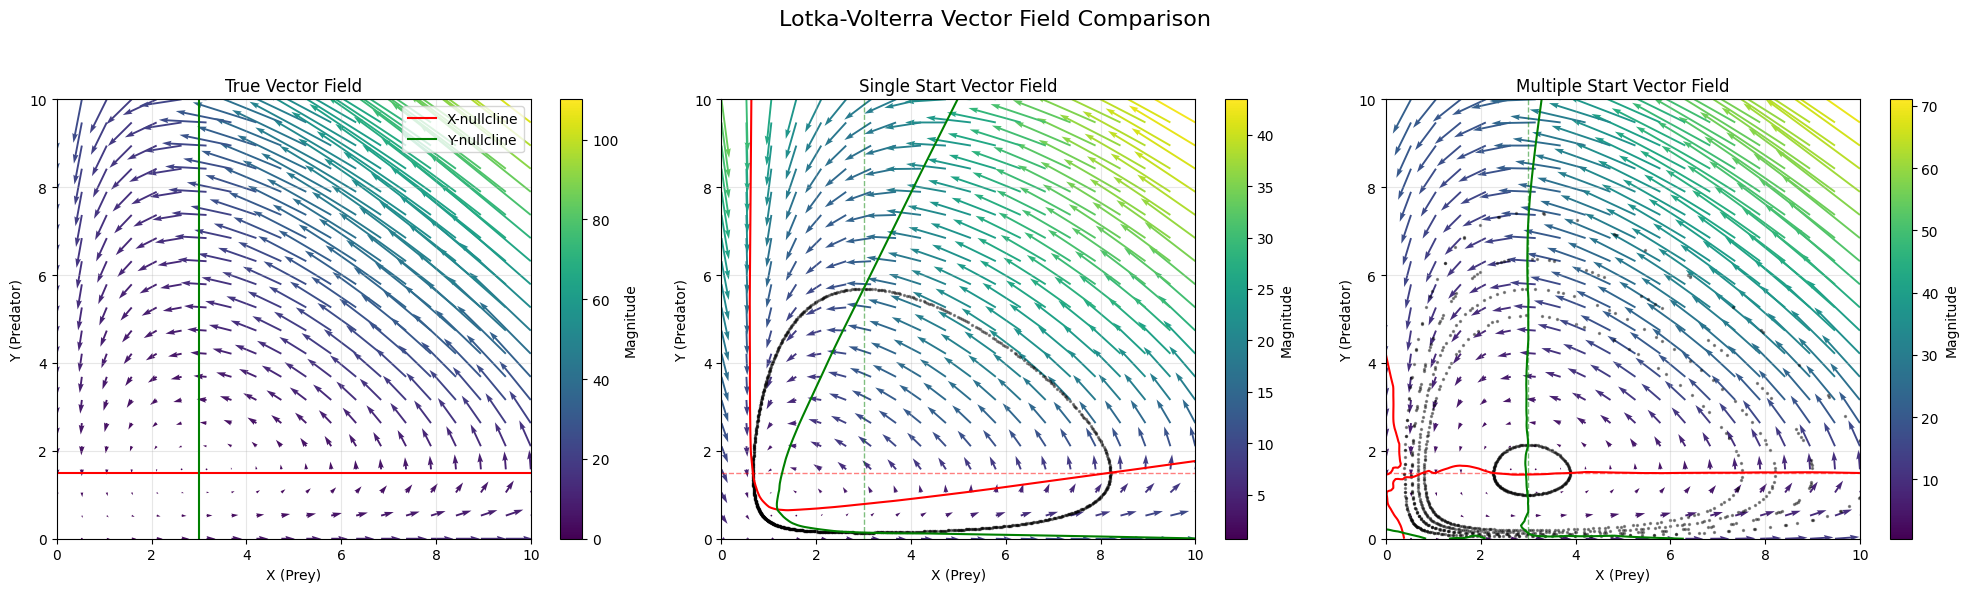

In [12]:
# IMPORTANT: Add this after you've trained your model fOde on the LV data

# Create and train a model with multiple starting points
single_start = [[5.0, 0.2]]  # A standard LV starting point
multi_start = [
    [5.0, 0.2],   # Original starting point
    [1.0, 3.0],   # Low prey, high predator
    [3.0, 1.0],   # Medium prey and predator
    [8.0, 0.5],   # High prey, low predator
    [0.5, 0.5]    # Low prey and predator
]

# Function to get states and derivatives from trajectories
def get_states_derivs(starting_points):
    """Generate trajectories and extract states and derivatives"""
    all_states, all_derivs = [], []
    
    for start_point in starting_points:
        # Generate trajectory from this starting point
        this_tdata = np.linspace(0, 12, 1281)  # LV typically has shorter time periods
        this_xdata = odeint(LV, start_point, this_tdata, args=(a, b, c, d))
    
        # Convert to tensors
        states = torch.tensor(this_xdata, dtype=torch.float64)
        derivs = torch.tensor([LV(state, 0, a, b, c, d) for state in this_xdata], dtype=torch.float64)
        
        all_states.append(states)
        all_derivs.append(derivs)
    
    return torch.cat(all_states), torch.cat(all_derivs)

# Get single and multi-start data
single_states, single_derivs = get_states_derivs(single_start)
multi_states, multi_derivs = get_states_derivs(multi_start)

# Train neural network models directly on the trajectory data
def train_nn_model(states, derivs, hidden_size=512, epochs=1000):
    """Train a neural network model directly on state/derivative pairs"""
    no_comp = states.shape[1]
    model = nnMTModule(no_comp, [hidden_size], dp=0)
    
    # Standardize outputs
    deriv_means = torch.mean(derivs, dim=0)
    deriv_stds = torch.std(derivs, dim=0)
    model.update_output_layer(deriv_means, deriv_stds)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        pred_derivs = model(states)
        mse_loss = torch.mean((pred_derivs - derivs) ** 2)
        l2_reg = sum(p.pow(2.0).sum() for p in model.parameters())
        total_loss = mse_loss + 1e-4 * l2_reg
        total_loss.backward()
        optimizer.step()
        
        # Print progress
        if epoch % (epochs // 10) == 0:
            print(f"Epoch {epoch}/{epochs}, Loss: {total_loss.item():.6f}")
    
    return model

# Train models on the single and multi-start data
print("Training single-start model...")
single_model = train_nn_model(single_states, single_derivs)

print("Training multi-start model...")
multi_model = train_nn_model(multi_states, multi_derivs)

# Compute vector fields
true_vf = compute_true_vector_field()
single_vf = compute_vector_field(single_model)
multi_vf = compute_vector_field(multi_model)

# Create visualization
plot_vector_field_comparison(
    true_vf, 
    single_vf, 
    multi_vf, 
    single_model, 
    multi_model, 
    single_states, 
    multi_states,
    filename="LV_vector_field_comparison.png"
)

Training single-start log-LV model…
Epoch 0/1000, Loss: 4.104401
Epoch 100/1000, Loss: 0.035716
Epoch 200/1000, Loss: 0.025116
Epoch 300/1000, Loss: 0.023878
Epoch 400/1000, Loss: 0.023221
Epoch 500/1000, Loss: 0.022675
Epoch 600/1000, Loss: 0.022191
Epoch 700/1000, Loss: 0.021732
Epoch 800/1000, Loss: 0.021279
Epoch 900/1000, Loss: 0.020829
Training multi-start log-LV model…
Epoch 0/1000, Loss: 5.064411
Epoch 100/1000, Loss: 0.081252
Epoch 200/1000, Loss: 0.047088
Epoch 300/1000, Loss: 0.037906
Epoch 400/1000, Loss: 0.033638
Epoch 500/1000, Loss: 0.031001
Epoch 600/1000, Loss: 0.028906
Epoch 700/1000, Loss: 0.027188
Epoch 800/1000, Loss: 0.025806
Epoch 900/1000, Loss: 0.024675


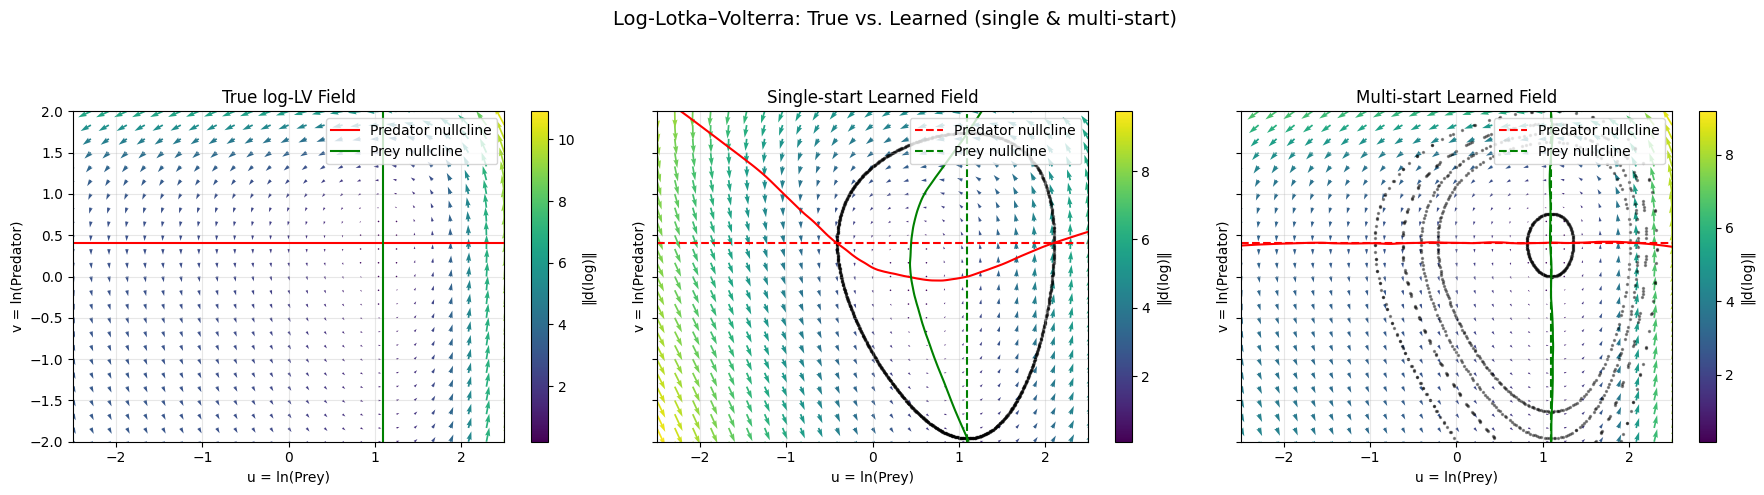

In [10]:
# ─────────────────────────────────────────────────────
# 1) LOG-SPACE VECTOR-FIELD HELPERS
# ─────────────────────────────────────────────────────
# Create and train a model with multiple starting points
single_start = [[5.0, 0.2]]  # A standard LV starting point
multi_start = [
    [5.0, 0.2],   # Original starting point
    [1.0, 3.0],   # Low prey, high predator
    [3.0, 1.0],   # Medium prey and predator
    [8.0, 0.5],   # High prey, low predator
    [0.5, 0.5]    # Low prey and predator
]

def compute_true_vector_field_log(grid_size=20,
                                  u_range=(-2, 3),
                                  v_range=(-2, 3)):
    """Return log-space mesh (U,V) and true dU,dV for LV."""
    us = np.linspace(u_range[0], u_range[1], grid_size)
    vs = np.linspace(v_range[0], v_range[1], grid_size)
    U, V = np.meshgrid(us, vs)

    # back to original scale
    X = np.exp(U)
    Y = np.exp(V)

    # d(logP)/dt = (1/P)dP/dt, etc.
    dU = (a*X - b*X*Y) / X
    dV = (c*X*Y - d*Y) / Y

    mag = np.sqrt(dU**2 + dV**2)
    return {'X': U, 'Y': V, 'U': dU, 'V': dV, 'magnitude': mag}


def compute_vector_field_log(model,
                             grid_size=20,
                             u_range=(-2, 3),
                             v_range=(-2, 3)):
    """Return log-space mesh and learned dU,dV from `model`."""
    us = np.linspace(u_range[0], u_range[1], grid_size)
    vs = np.linspace(v_range[0], v_range[1], grid_size)
    U, V = np.meshgrid(us, vs)
    dU = np.zeros_like(U)
    dV = np.zeros_like(V)

    model.eval()
    with torch.no_grad():
        for i in range(grid_size):
            for j in range(grid_size):
                inp = torch.tensor([[U[i,j], V[i,j]]], dtype=torch.float64)
                out = model(inp).cpu().numpy().squeeze(0)
                dU[i,j], dV[i,j] = out[0], out[1]

    mag = np.sqrt(dU**2 + dV**2)
    return {'X': U, 'Y': V, 'U': dU, 'V': dV, 'magnitude': mag}


def compute_estimated_nullclines_log(model,
                                     resolution=200,
                                     u_range=(-2, 3),
                                     v_range=(-2, 3)):
    """Returns dense dU,dV so that contour(level=0) gives estimated nullclines."""
    us = np.linspace(u_range[0], u_range[1], resolution)
    vs = np.linspace(v_range[0], v_range[1], resolution)
    U, V = np.meshgrid(us, vs)
    dU = np.zeros_like(U)
    dV = np.zeros_like(V)

    model.eval()
    with torch.no_grad():
        for i in range(resolution):
            for j in range(resolution):
                inp = torch.tensor([[U[i,j], V[i,j]]], dtype=torch.float64)
                out = model(inp).cpu().numpy().squeeze(0)
                dU[i,j], dV[i,j] = out[0], out[1]

    return {'X': U, 'Y': V, 'U': dU, 'V': dV}


def sample_training_data_for_visualization(states, max_points=1000):
    """Uniformly subsample at most max_points from a torch.Tensor of shape (N,2)."""
    n = states.shape[0]
    if n <= max_points:
        return states
    idx = np.linspace(0, n-1, max_points, dtype=int)
    return states[idx]


def plot_vector_field_comparison_log(true_vf,
                                     single_vf,
                                     multi_vf,
                                     single_model,
                                     multi_model,
                                     single_states,
                                     multi_states,
                                     u_range=(-2, 3),
                                     v_range=(-2, 3),
                                     filename="logLV_vector_field_comparison.png"):
    """Three-panel: true vs single-start vs multi-start log-LV fields + nullclines."""
    # true nullcline values
    v_nc = np.log(a/b)   # dU=0 ⇒ a - b e^v =0
    u_nc = np.log(d/c)   # dV=0 ⇒ -d + c e^u =0

    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)
    for ax, vf, states, model, title in zip(
        axes,
        [true_vf, single_vf, multi_vf],
        [None, single_states, multi_states],
        [None, single_model, multi_model],
        ["True log-LV Field",
         "Single-start Learned Field",
         "Multi-start Learned Field"]
    ):
        # quiver
        Q = ax.quiver(vf['X'], vf['Y'], vf['U'], vf['V'],
                      vf['magnitude'], cmap='viridis',
                      scale_units='xy', angles='xy', scale=40, width=0.004)
        fig.colorbar(Q, ax=ax, label="‖d(log)‖")

        # true nullclines: solid for true, dashed for learned
        ls = '-' if states is None else '--'
        ax.axhline(v_nc, color='r', linestyle=ls, lw=1.5, label="Predator nullcline")
        ax.axvline(u_nc, color='g', linestyle=ls, lw=1.5, label="Prey nullcline")

        # estimated nullclines & data scatter on learned panels
        if states is not None:
            nulls = compute_estimated_nullclines_log(
                        model, u_range=u_range, v_range=v_range)
            ax.contour(nulls['X'], nulls['Y'], nulls['U'],
                       levels=[0], colors='r', linewidths=1.5)
            ax.contour(nulls['X'], nulls['Y'], nulls['V'],
                       levels=[0], colors='g', linewidths=1.5)

            samp = sample_training_data_for_visualization(states)
            ax.scatter(samp[:,0].numpy(), samp[:,1].numpy(),
                       s=2, c='k', alpha=0.4)

        ax.set_title(title)
        ax.set_xlabel('u = ln(Prey)')
        ax.set_ylabel('v = ln(Predator)')
        ax.set_xlim(u_range)
        ax.set_ylim(v_range)
        ax.grid(alpha=0.3)
        ax.legend(loc='upper right')

    fig.suptitle("Log-Lotka–Volterra: True vs. Learned (single & multi-start)", fontsize=14)
    plt.tight_layout(rect=[0,0,1,0.92])
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()


# ─────────────────────────────────────────────────────
# 2) BUILD & TRAIN ON LOG-SPACE TRAJECTORIES
# ─────────────────────────────────────────────────────

def get_log_states_derivs(starting_points, t_max=12, n_steps=1281):
    """Simulate LV from each start, return (u,v) and (du,dv) torch tensors."""
    all_u, all_v, all_du, all_dv = [], [], [], []
    tgrid = np.linspace(0, t_max, n_steps)
    for P0, D0 in starting_points:
        traj = odeint(LV, [P0, D0], tgrid, args=(a,b,c,d))
        uv    = np.log(traj)               # shape (n_steps,2)
        deriv = np.array([LV(pt,0,a,b,c,d) for pt in traj])
        duv   = deriv / traj               # [dP/P, dD/D]
        all_u .append(uv[:,0]); all_v .append(uv[:,1])
        all_du.append(duv[:,0]); all_dv.append(duv[:,1])

    S = torch.tensor(
        np.column_stack([np.concatenate(all_u), np.concatenate(all_v)]),
        dtype=torch.float64
    )
    D = torch.tensor(
        np.column_stack([np.concatenate(all_du), np.concatenate(all_dv)]),
        dtype=torch.float64
    )
    return S, D

# single vs multi
single_states, single_derivs = get_log_states_derivs(single_start)
multi_states,  multi_derivs  = get_log_states_derivs(multi_start)

# train both nets
print("Training single-start log-LV model…")
single_model = train_nn_model(single_states, single_derivs,
                              hidden_size=512, epochs=1000)

print("Training multi-start log-LV model…")
multi_model  = train_nn_model(multi_states,  multi_derivs,
                              hidden_size=512, epochs=1000)

# ─────────────────────────────────────────────────────
# 3) COMPUTE & PLOT
# ─────────────────────────────────────────────────────
u_range = (-2.5, 2.5)
v_range = (-2.0, 2.0)

true_vf   = compute_true_vector_field_log(grid_size=25,
                                          u_range=u_range,
                                          v_range=v_range)
single_vf = compute_vector_field_log(single_model,
                                     grid_size=25,
                                     u_range=u_range,
                                     v_range=v_range)
multi_vf  = compute_vector_field_log(multi_model,
                                     grid_size=25,
                                     u_range=u_range,
                                     v_range=v_range)

plot_vector_field_comparison_log(
    true_vf,
    single_vf,
    multi_vf,
    single_model,
    multi_model,
    single_states,
    multi_states,
    u_range=u_range,
    v_range=v_range,
    filename="logLV_vector_field_comparison.png"
)


## npode

In [11]:
 import sys
print(sys.executable)


/mnt/home/sykim/.conda/envs/py39/bin/python


In [12]:
import tensorflow as tf


2025-04-25 16:52:36.206739: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745567556.217013 1307772 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745567556.219972 1307772 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745567556.229026 1307772 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745567556.229039 1307772 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745567556.229040 1307772 computation_placer.cc:177] computation placer alr

In [16]:
print(tf.__version__)

2.19.0


In [23]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

# Add path to NPODE code
sys.path.insert(0, '/mnt/home/sykim/MAGI-TS/old_experiment/scripts/npode')
# /home/gimlullu6/MAGI-TS-1/old_experiment/scripts/npode
from npde import NPODE  # Import the NPODE class

In [15]:
def train_npode_model(states, derivs, inducing_points=100, iterations=500):
    """
    Train an NPODE model on the given states and derivatives
    
    Args:
        states: Tensor of state points
        derivs: Tensor of derivatives
        inducing_points: Number of inducing points for GP
        iterations: Number of training iterations
        
    Returns:
        Trained NPODE model
    """
    print("Training NPODE model...")
    
    # Convert data to numpy if needed
    if isinstance(states, torch.Tensor):
        states_np = states.numpy()
        derivs_np = derivs.numpy()
    else:
        states_np = states
        derivs_np = derivs
    
    # Initialize NPODE model
    npode_model = NPODE(input_dim=2)  # 2D for LV
    
    # Set up inducing points (evenly spaced across the data range)
    x_min, x_max = states_np[:, 0].min(), states_np[:, 0].max()
    y_min, y_max = states_np[:, 1].min(), states_np[:, 1].max()
    
    # Create grid of inducing points
    grid_size = int(np.sqrt(inducing_points))
    x_grid = np.linspace(x_min, x_max, grid_size)
    y_grid = np.linspace(y_min, y_max, grid_size)
    X, Y = np.meshgrid(x_grid, y_grid)
    Z = np.vstack([X.flatten(), Y.flatten()]).T
    
    # Train the model
    npode_model.train(states_np, derivs_np, Z, iterations=iterations)
    
    return npode_model

In [17]:
def compute_npode_vector_field(npode_model, grid_size=20, x_range=(0, 10), y_range=(0, 10)):
    """
    Compute vector field for NPODE model
    
    Args:
        npode_model: Trained NPODE model
        grid_size: Grid resolution
        grid_size: Grid resolution
        x_range: Range for x axis
        y_range: Range for y axis
        
    Returns:
        Dictionary with vector field data
    """
    x = np.linspace(x_range[0], x_range[1], grid_size)
    y = np.linspace(y_range[0], y_range[1], grid_size)
    X, Y = np.meshgrid(x, y)
    U, V = np.zeros_like(X), np.zeros_like(Y)
    
    # Compute derivatives at each grid point
    for i in range(grid_size):
        for j in range(grid_size):
            state = np.array([[X[i, j], Y[i, j]]])
            derivs = npode_model.predict(state)
            U[i, j], V[i, j] = derivs[0, 0], derivs[0, 1]
    
    return {'X': X, 'Y': Y, 'U': U, 'V': V, 'magnitude': np.sqrt(U**2 + V**2)}

In [18]:
def plot_npode_vs_magix(true_vf, npode_vf, magix_vf, filename="npode_vs_magix_comparison.png"):
    """
    Create a comparison plot between NPODE and MAGI-X
    
    Args:
        true_vf: True vector field
        npode_vf: NPODE vector field
        magix_vf: MAGI-X vector field
        filename: Output file name
    """
    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # Calculate true nullclines for LV model
    # X-nullcline: Y = a/b
    # Y-nullcline: X = d/c
    
    # Plot true vector field
    q0 = axes[0].quiver(true_vf['X'], true_vf['Y'], true_vf['U'], true_vf['V'], 
                       true_vf['magnitude'], cmap=plt.cm.viridis, 
                       scale_units='xy', angles='xy', scale=25, width=0.004)
    fig.colorbar(q0, ax=axes[0], label='Magnitude')
    axes[0].axhline(y=a/b, color='r', linestyle='-', linewidth=1.5, label='X-nullcline')
    axes[0].axvline(x=d/c, color='g', linestyle='-', linewidth=1.5, label='Y-nullcline')
    axes[0].set_title('True Vector Field')
    axes[0].legend(loc='upper right')
    
    # Plot NPODE vector field
    q1 = axes[1].quiver(npode_vf['X'], npode_vf['Y'], npode_vf['U'], npode_vf['V'], 
                       npode_vf['magnitude'], cmap=plt.cm.viridis, 
                       scale_units='xy', angles='xy', scale=25, width=0.004)
    fig.colorbar(q1, ax=axes[1], label='Magnitude')
    
    # Plot true nullclines with dashed lines for reference
    axes[1].axhline(y=a/b, color='r', linestyle='--', linewidth=1.0, alpha=0.5)
    axes[1].axvline(x=d/c, color='g', linestyle='--', linewidth=1.0, alpha=0.5)
    
    # Add NPODE-estimated nullclines (would need higher resolution)
    # This would be similar to compute_estimated_nullclines but for NPODE
    
    axes[1].set_title('NPODE Vector Field')
    
    # Plot MAGI-X vector field
    q2 = axes[2].quiver(magix_vf['X'], magix_vf['Y'], magix_vf['U'], magix_vf['V'], 
                       magix_vf['magnitude'], cmap=plt.cm.viridis, 
                       scale_units='xy', angles='xy', scale=25, width=0.004)
    fig.colorbar(q2, ax=axes[2], label='Magnitude')
    
    # Plot true nullclines with dashed lines for reference
    axes[2].axhline(y=a/b, color='r', linestyle='--', linewidth=1.0, alpha=0.5)
    axes[2].axvline(x=d/c, color='g', linestyle='--', linewidth=1.0, alpha=0.5)
    
    axes[2].set_title('MAGI-X Vector Field')
    
    # Set common properties
    for ax in axes:
        ax.set_xlabel('X (Prey)')
        ax.set_ylabel('Y (Predator)')
        ax.set_xlim([0, 10])
        ax.set_ylim([0, 10])
        ax.grid(True, alpha=0.3)
    
    # Set title
    fig.suptitle('Lotka-Volterra: NPODE vs MAGI-X Comparison', fontsize=16)
    
    # Save figure
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

In [19]:
# Train NPODE model on the same data used for MAGI-X
npode_single = train_npode_model(single_states, single_derivs, iterations=500)
npode_multi = train_npode_model(multi_states, multi_derivs, iterations=500)

# Compute vector fields
npode_single_vf = compute_npode_vector_field(npode_single)
npode_multi_vf = compute_npode_vector_field(npode_multi)

# Create comparison plots
plot_npode_vs_magix(
    true_vf,
    npode_single_vf,
    single_vf,
    filename="npode_vs_magix_single_comparison.png"
)

plot_npode_vs_magix(
    true_vf,
    npode_multi_vf,
    multi_vf,
    filename="npode_vs_magix_multi_comparison.png"
)

Training NPODE model...


TypeError: __init__() got an unexpected keyword argument 'input_dim'

In [24]:
# import required packages
import time
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.integrate import odeint

# import MAGI-X packages
from scripts.magix.dynamic import nnSTModule, nnMTModule # neural network module
from scripts.magix.inference import FMAGI # inferred module

In [26]:
import numpy as np
import tensorflow as tf
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

from kernels import OperatorKernel
from npde_helper import build_model, fit_model

def train_npode_model(states, derivs, t,
                      inducing_points=100,
                      num_iter=500):
    """
    Fit the TF-based NPODE to 2D data.
    states:    (N,2) numpy array of (x,y) points
    derivs:    (N,2) numpy array of (dx/dt,dy/dt)
    t:         (N,)  numpy array of time-stamps
    inducing_points: total number M = inducing_points
    num_iter:  how many optimizer steps
    Returns: (sess, trained_model)
    """
    # 1) Grid of inducing locations Z0
    x_min, x_max = states[:,0].min(), states[:,0].max()
    y_min, y_max = states[:,1].min(), states[:,1].max()
    grid_size = int(np.sqrt(inducing_points))
    xs = np.linspace(x_min, x_max, grid_size)
    ys = np.linspace(y_min, y_max, grid_size)
    Xg, Yg = np.meshgrid(xs, ys)
    Z0 = np.vstack([Xg.ravel(), Yg.ravel()]).T   # shape (M,2)

    # 2) Initial U0 by linear interpolation of observed derivs
    U0 = griddata(states, derivs,
                  Z0,
                  method='linear',
                  fill_value=0.0)                # (M,2)

    # 3) Noise‐variance init
    sn0 = np.zeros(2)                         # one σ² per dimension

    # 4) GP kernel
    kern = OperatorKernel(sf0=1.0,
                          ell0=[1.0,1.0],
                          ktype="id")

    # 5) Build TensorFlow session and model
    tf.reset_default_graph()
    sess = tf.Session()

    npde = build_model(
        sess=sess,
        t=[t],
        Y=[states],
        model='ode',       # ODE case
        sf0=1.0,
        ell0=[1.0,1.0],
        W=grid_size,       # grid width per dim
        ktype="id",
        whiten=True,
        fix_ell=False,
        fix_sf=False,
        fix_Z=False,
        fix_U=False,
        fix_sn=False
    )

    # 6) Fit with MAGI-TS’s optimizer
    #    Returns the inferred initial x0 (unused here) and the model
    _, trained = fit_model(
        sess=sess,
        model=npde,
        t=[t],
        Y=[states],
        Nw=10,
        num_iter=num_iter,
        print_every=50,
        plot_=False
    )

    return sess, trained

def compute_vector_field(model, sess,
                         grid_size=20,
                         x_range=(0,10),
                         y_range=(0,10)):
    """
    On a regular grid, evaluate the learned GP derivative f.
    Returns dict with X,Y,U,V,magnitude.
    """
    xs = np.linspace(x_range[0], x_range[1], grid_size)
    ys = np.linspace(y_range[0], y_range[1], grid_size)
    X, Y = np.meshgrid(xs, ys)
    U = np.zeros_like(X)
    V = np.zeros_like(Y)

    for i in range(grid_size):
        for j in range(grid_size):
            pt = np.array([[X[i,j], Y[i,j]]])
            # run the TF graph to get f(pt)
            u_vec = sess.run(model.f(pt))  # shape (1,2)
            U[i,j], V[i,j] = u_vec[0,0], u_vec[0,1]

    mag = np.sqrt(U**2 + V**2)
    return {'X': X, 'Y': Y, 'U': U, 'V': V, 'magnitude': mag}

def plot_npode_vs_magix(true_vf, npode_vf, magix_vf):
    """
    Three‐panel quiver comparison.
    """
    fig, axes = plt.subplots(1,3,figsize=(18,6))
    for ax, vf, title in zip(axes,
                             (true_vf, npode_vf, magix_vf),
                             ('True VF','NPODE VF','MAGI-X VF')):
        q = ax.quiver(vf['X'], vf['Y'],
                      vf['U'], vf['V'],
                      vf['magnitude'],
                      scale_units='xy',
                      angles='xy',
                      scale=25, width=0.004)
        fig.colorbar(q, ax=ax)
        ax.set_title(title)
        ax.set_xlabel('x'); ax.set_ylabel('y')
        ax.set_xlim(true_vf['X'].min(), true_vf['X'].max())
        ax.set_ylim(true_vf['Y'].min(), true_vf['Y'].max())
        ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# ──────────────────────────────────────────────────────────────
# Example usage:

# 1) Load or define your LV data:
#    `single_states`  shape (N,2), `single_derivs` shape (N,2), `t` shape (N,)
# 2) Compute true vector field by your existing `compute_true_vector_field` (unchanged)
# 3) Train:
# sess, npode_model = train_npode_model(
#     single_states, single_derivs, t,
#     inducing_points=400,   # e.g. 20×20 grid
#     num_iter=500
# )
#
# 4) Compute learned VF:
# npode_vf = compute_vector_field(npode_model, sess,
#                                 grid_size=20,
#                                 x_range=(0,10), y_range=(0,10))
#
# 5) Likewise compute `magix_vf` via your MAGI-X code, then:
# plot_npode_vs_magix(true_vf, npode_vf, magix_vf)


In [27]:
# ─── Cell 2: Simulate Lotka–Volterra data ──────────────────────────────────
def simulate_lv(a=1.5, b=1.0, c=1.0, d=3.0,
                x0=(5.0,0.2), t_end=12, n_pts=200):
    def lv(x, t):
        return [a*x[0] - b*x[0]*x[1],
                c*x[0]*x[1] - d*x[1]]
    t = np.linspace(0, t_end, n_pts)
    X = odeint(lv, x0, t)              # (n_pts,2)
    dX = np.vstack([lv(xi, ti) for xi,ti in zip(X,t)])  # (n_pts,2)
    return t, X, dX

# run it
t, states, derivs = simulate_lv()
print("states shape:", states.shape, "derivs shape:", derivs.shape)


states shape: (200, 2) derivs shape: (200, 2)


In [28]:
# ─── Cell 3: True vector field ─────────────────────────────────────────────
true_vf = compute_true_vector_field(
    grid_size=20,
    x_range=(states[:,0].min(), states[:,0].max()),
    y_range=(states[:,1].min(), states[:,1].max())
)


In [29]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
# # monkey-patch the old v1 names back onto tf
# tf.cholesky = tf.linalg.cholesky
# tf.matrix_triangular_solve = tf.linalg.triangular_solve

In [ ]:
# ─── Cell 4: Train the TensorFlow NPODE ────────────────────────────────────
# Reset TF graph so repeated runs in notebook won't clash
tf.reset_default_graph()

sess, npode_model = train_npode_model(
    states, derivs, t,
    inducing_points=400,  # 20×20 grid
    num_iter=500
)


Model being initialized...


I0000 00:00:1745568604.555862 1313340 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9916 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1745568604.556405 1313340 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22455 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:25:00.0, compute capability: 8.6
I0000 00:00:1745568604.556873 1313340 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 2768 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:41:00.0, compute capability: 8.6
I0000 00:00:1745568604.557373 1313340 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 3370 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:61:00.0, compute capability: 8.6
I0000 00:00:1745568604.557826 1313340 gpu_device.cc:2019] C

AttributeError: module 'tensorflow' has no attribute 'cholesky'

: 

## Attempt 2



In [54]:
# ─── Cell 2: Simulate log-LV trajectories ──────────────────────────────────
a, b, c, d = 1.5, 1.0, 1.0, 3.0

def LV(x, t, a, b, c, d):
    """Original LV in (P,D)-space dP/dt, dD/dt"""
    return [a*x[0] - b*x[0]*x[1],
            c*x[0]*x[1] - d*x[1]]

def get_log_lv_data(starts, t_max=12, n_steps=1000):
    """Return arrays U=(u,v) and dU=(du,dv) for each start, stacked."""
    all_uv = []
    all_duv = []
    tgrid = np.linspace(0, t_max, n_steps)
    for P0, D0 in starts:
        traj = odeint(LV, [P0, D0], tgrid, args=(a,b,c,d))
        uv    = np.log(traj)                              # (n_steps,2)
        deriv = np.vstack([LV(pt,ti,a,b,c,d) 
                           for pt,ti in zip(traj,tgrid)])  # (n_steps,2)
        duv   = deriv / traj                              # elementwise
        all_uv .append(uv)
        all_duv.append(duv)
    U  = np.concatenate(all_uv, axis=0)   # (M,2)
    dU = np.concatenate(all_duv,axis=0)   # (M,2)
    return U, dU

# choose single-start vs multi-start
single_start = [(5.0,0.2)]
multi_start  = [(5.0,0.2),(1.0,3.0),(3.0,1.0),(8.0,0.5),(0.5,0.5)]

U_single, dU_single = get_log_lv_data(single_start)
U_multi,  dU_multi  = get_log_lv_data(multi_start)

print("Single:", U_single.shape, dU_single.shape)
print("Multi: ", U_multi.shape,  dU_multi.shape)


Single: (1000, 2) (1000, 2)
Multi:  (5000, 2) (5000, 2)


In [55]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


In [58]:
# ─── Cell 3: Build & train the TF-NPODE on log-data ────────────────────────
from kernels import OperatorKernel
from npde_helper import build_model, fit_model

def train_npode_log(U, dU, t_max=12,
                    inducing_points=400,
                    num_iter=500):
    """
    Train TF NPODE on (u,v)->(du,dv) data.
    U:   (M,2) array of log-states
    dU:  (M,2) array of log-derivatives
    """
    # 1) build grid of inducing inputs in log-space
    u_min, u_max = U[:,0].min(), U[:,0].max()
    v_min, v_max = U[:,1].min(), U[:,1].max()
    G = int(np.sqrt(inducing_points))
    us = np.linspace(u_min, u_max, G)
    vs = np.linspace(v_min, v_max, G)
    Ug, Vg = np.meshgrid(us, vs)
    Z0 = np.vstack([Ug.ravel(), Vg.ravel()]).T

    # 2) init U0 by linear interp of your stacked dU
    from scipy.interpolate import griddata
    U0 = griddata(U, dU, Z0, method='linear', fill_value=0.0)

    # 3) noise-variance init (per dim)
    sn0 = np.zeros(2)

    # 4) a simple id-kernel in 2D
    kern = OperatorKernel(sf0=1.0, ell0=[1.,1.], ktype="id")

    # 5) TensorFlow graph & session
    tf.reset_default_graph()
    sess = tf.Session()

    # build_model uses your npde_helper.build_model (TF1.x)
    npde = build_model(
        sess=sess,
        t=[np.linspace(0, t_max, U.shape[0])],  # dummy time grid
        Y=[U],               # but we're really fitting derivatives...
        model='ode',
        sf0=1.0,
        ell0=[1.0,1.0],
        W=G,
        ktype="id",
        whiten=True
    )

    # fit_model then optimizes the latent trajectory & kernel to match dU
    # note Y here is the log-states U; the NPODE objective uses the GP derivative to match dU
    _, trained = fit_model(
        sess=sess,
        model=npde,
        t=[np.linspace(0, t_max, U.shape[0])],
        Y=[U],
        Nw=10,
        num_iter=num_iter,
        plot_=False
    )

    return sess, trained

# train on single & multi
sess_s, npode_s = train_npode_log(U_single, dU_single, inducing_points=400, num_iter=500)
sess_m, npode_m = train_npode_log(U_multi,  dU_multi,   inducing_points=400, num_iter=500)


TypeError: __init__() got an unexpected keyword argument 'initial_value'